### Monthly Precipitation Mapping and Statistics 

This notebook processes monthly precipitation data from the **CHIRPS Daily** collection  
for the year **2024**. It generates visual maps  
and summary statistics, including **spatial mean and standard deviation** of rainfall for each month.

The workflow uses the **Google Earth Engine Python API (`ee`)** along with  
`matplotlib`, `PIL`, and `requests` for visualization.

---

### Parameters

- `roi`: An `ee.FeatureCollection` representing the region of interest 
- `monthly_images`: A list of 12 `ee.Image` objects, each representing total monthly rainfall (mm).

---

### Workflow Details

- Loads the CHIRPS Daily ImageCollection and filters it by **month** for **2024**.
- Sums daily precipitation to get **total monthly precipitation**.
- Clips each monthly image to the specified **ROI**.
- For each image:
  - Generates a visual **thumbnail** using a fixed color palette (`0–500 mm` scale).
  - Enhances contrast and replaces black background with white.
  - Displays the 12 monthly maps in a **4x3 grid layout**.
- Adds a **vertical colorbar** for precipitation scale reference.
- Computes **zonal statistics** (mean and standard deviation) within the ROI.
- Plots a **bar chart** showing average monthly precipitation with error bars  
  indicating ±1 standard deviation.

---

### Output

- A **grid of 12 enhanced precipitation maps** (Jan–Dec) clipped to the AOI polygon.
- A **bar chart** summarizing monthly average precipitation with variability.

Author: Jessé Burlamaque


In [1]:
!pip install geemap


In [1]:
import ee
import geemap

In [2]:
ee.Authenticate()

True

In [3]:
# Inicializar a Earth Engine
ee.Initialize()

In [4]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import matplotlib.colors as mcolors
import numpy as np

In [ ]:
# Define region of interest
roi = ee.FeatureCollection('users/burlamaquejess/limites_cautario')

# CHIRPS Daily data
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')

year = 2024 


monthly_images = [] 

for month in range(1, 13):
    start = ee.Date.fromYMD(year, month, 1)  
    end = start.advance(1, 'month')

    filtered = chirps.filterDate(start, end)
    monthly_precip = filtered.reduce(ee.Reducer.sum())  # ← monthly sum
    monthly_precip = monthly_precip.clip(roi)

    monthly_images.append(monthly_precip)

# Palette and scale
palette_hex = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
palette_rgb = [mcolors.hex2color(c) for c in palette_hex]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_chirps", palette_rgb)
vmin, vmax = 0, 500

# Month titles
titles = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

C:\Users\JesseBurlamaque\AppData\Local\Temp\ipykernel_13936\1028727306.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


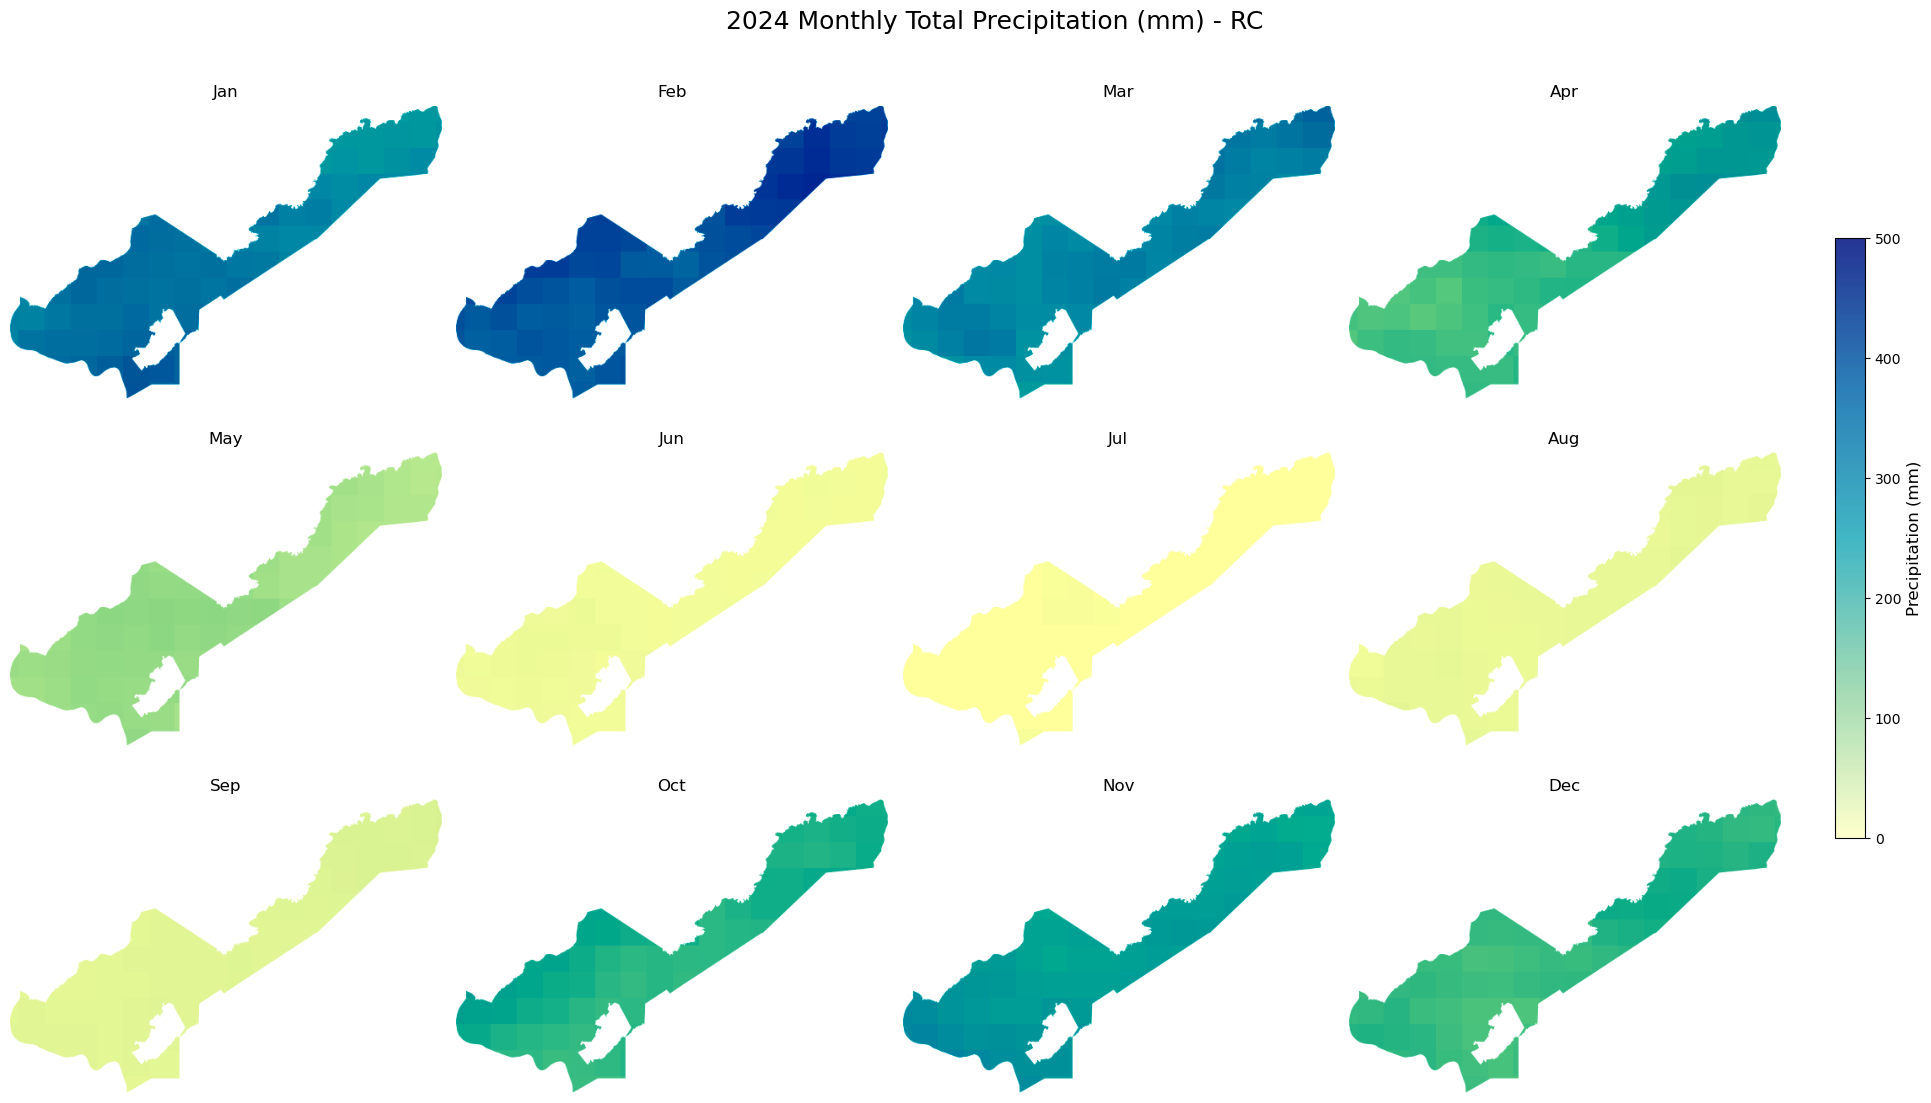

In [ ]:
# Grid 4x3
ncols, nrows = 4, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12))

# Main title
fig.suptitle(f"{year} Monthly Total Precipitation (mm) - RC", fontsize=18, y=0.94)

# Loop 
for i, (image, title) in enumerate(zip(monthly_images, titles)):
    row, col = divmod(i, ncols)
    ax = axs[row, col]

    params = {
        'dimensions': 512,
        'region': roi.geometry().getInfo(),
        'format': 'png',
        'min': vmin,
        'max': vmax,
        'palette': palette_hex
    }

    url = image.getThumbURL(params)
    response = requests.get(url)

    img = Image.open(BytesIO(response.content)).convert("RGBA")
    background = Image.new("RGBA", img.size, (255, 255, 255, 255))
    img = Image.alpha_composite(background, img)

    enhancer = ImageEnhance.Contrast(img.convert("RGB"))
    img_enhanced = enhancer.enhance(2.0)

    ax.imshow(img_enhanced)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=cbar_ax, orientation='vertical')
cb.set_label('Precipitation (mm)', fontsize=12)

# Layout with space for the title and colorbar
plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

In [23]:
print("monthly_images:", len(monthly_images))


monthly_images: 12


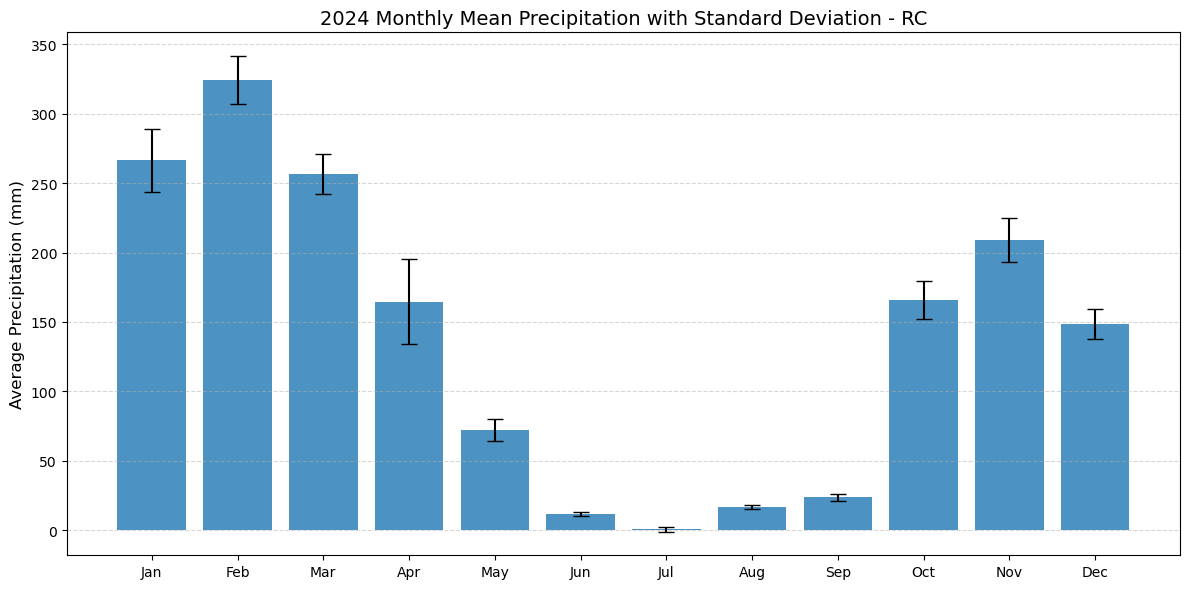

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Clear lists
mean_precip = []
std_precip = []

# Loop over the 12 months
for month_img in monthly_images:
    stats = month_img.reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=roi.geometry(),
        scale=5000,
        maxPixels=1e13
    ).getInfo()

    mean = stats.get('precipitation_sum_mean', np.nan)
    std = stats.get('precipitation_sum_stdDev', np.nan)

    mean_precip.append(mean)
    std_precip.append(std)

# Months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Check
if len(mean_precip) != 12:
    raise ValueError("A lista mean_precip não tem 12 valores. Verifique se monthly_images está correta.")

# Bar chart with error bars
plt.figure(figsize=(12, 6))
plt.bar(months, mean_precip, yerr=std_precip, capsize=6, color='#2c7fb8', alpha=0.85)

plt.ylabel('Average Precipitation (mm)', fontsize=12)
plt.title(f"{year} Monthly Mean Precipitation with Standard Deviation - RC", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show() 
